# Chambord Stones Project

## Overview
This project demonstrates an automatic mask generation process using deep learning techniques. We apply a segmentation model to detect and create masks for stone structures in images. The workflow includes environment setup, image processing, mask generation with the SAM model, and visualization of both intermediate and final results.

### Step 1: Set-Up Environment

In this section, we import the necessary libraries:
- **NumPy** for numerical operations.
- **Matplotlib** for plotting and visualization.
- **OpenCV (cv2)** for image processing.
- **Supervision** for enhanced annotation of results.


In [22]:
import numpy as np 
# import torch
import matplotlib.pyplot as plt 
import cv2
# import math
import supervision as sv

### Step 2: Define Utility Functions

We define a helper function `show_anns` that overlays the generated masks on the image.

In [23]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Step 3: Load and Display the Image

Here, we load the target image using OpenCV, convert its color space from BGR to RGB, and display it using Matplotlib.

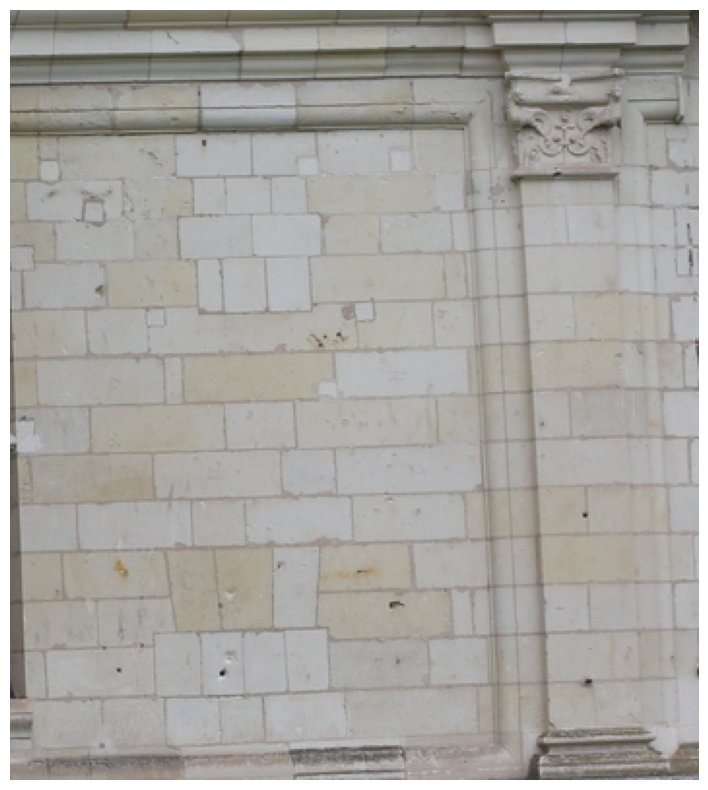

In [24]:
image = cv2.imread('../data/refined/FSE-stones/FSE_35_001-stones.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

### Step 4: Initialize the SAM Model for Mask Generation

In this section, we import additional modules and initialize the Segment Anything Model (SAM) for automatic mask generation. We load the pre-trained weights and configure the model on the selected device (CPU in this example).

In [25]:
import sys
sys.path.append("../third_party/segment-anything/")  
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

### Step 5: Generate and Explore Masks

We generate segmentation masks using the initialized SAM model and then examine the number of masks along with the keys of the first mask to understand its structure.

In [26]:
masks = mask_generator.generate(image)

In [27]:
print(len(masks))
print(masks[0].keys())

137
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


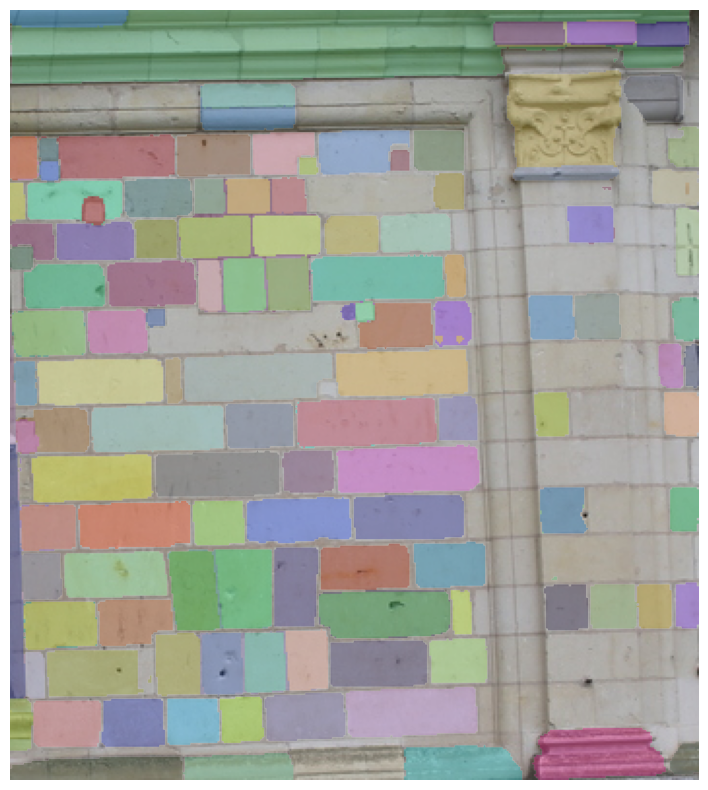

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Mask Data Structure Explanation

Mask generation returns a list of masks, where each mask is a dictionary containing:
- **segmentation**: the binary mask.
- **area**: the area of the mask in pixels.
- **bbox**: the bounding box in XYWH format.
- **predicted_iou**: the model’s predicted quality of the mask.
- **point_coords**: the sampled input point for generating the mask.
- **stability_score**: an additional quality measure.
- **crop_box**: the crop of the image used for mask generation.

### Show All Masks Overlayed on the Image

This section overlays all generated masks on the original image to visually verify the segmentation results.

### Step 6: Automatic Mask Generation Options

We configure an alternative mask generator with different parameters to generate more refined masks. These parameters control point sampling, thresholding for mask quality, and post-processing steps.

In [29]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [30]:
masks2 = mask_generator_2.generate(image)

In [31]:
len(masks2)

216

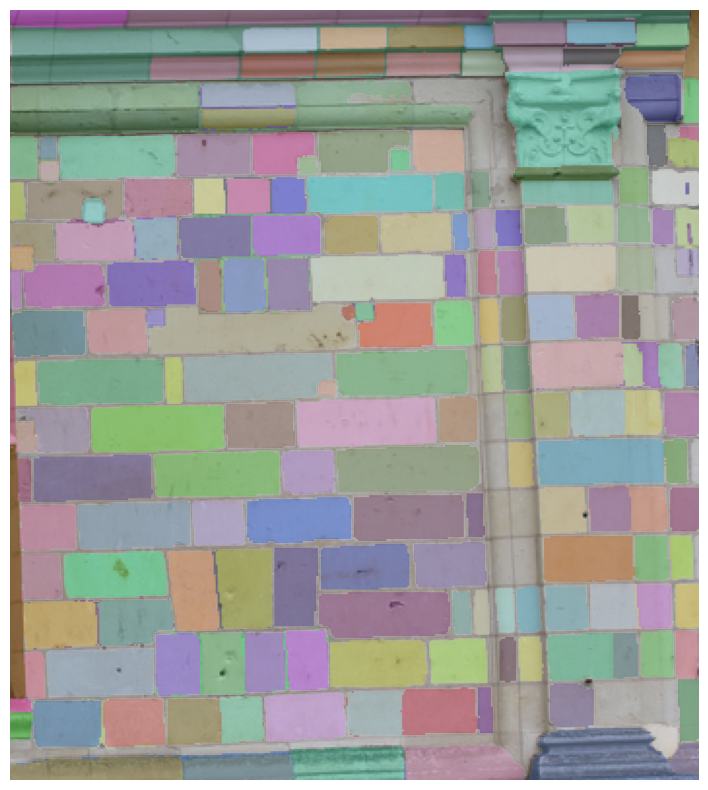

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

### Step 7: Build the Final Binary Mask

We combine the individual segmentation masks into one consolidated binary mask. This involves aggregating the masks, applying thresholding, and visualizing the result to ensure a clean final mask.

In [33]:
def build_totalmask(pred):
    # Create blank masks with the same shape as the SAM segmentation masks
    total_mask = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
    total_mask2 = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
    
    # TP is a reference area; adjust this value based on your image dimensions if needed.
    TP = 256 * 256
    for seg in pred:
        wp = seg['segmentation'].sum()
        perc = round((wp / TP) * 100, 2)
        print("White pixels %:", str(perc) + "%", "| White px:", wp)
        if perc > 1:
            total_mask += seg['segmentation']
            total_mask2 = np.logical_or(total_mask2, seg['segmentation'])
    
    # Convert the logical mask to uint8
    total_mask2 = (total_mask2 * 1).astype(np.uint8)
    
    # Use Otsu thresholding to create a binary mask
    _, total_mask_bin = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    _, total_mask2_bin = cv2.threshold(total_mask2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Display the non-overlapping binary mask for verification
    plt.figure(figsize=(10,10))
    plt.imshow(total_mask2_bin, cmap='gray')
    plt.title("Binary Mask (Non-overlapping)")
    plt.axis('off')
    plt.show()
    
    return total_mask_bin

White pixels %: 1.39% | White px: 909
White pixels %: 1.7% | White px: 1114
White pixels %: 1.98% | White px: 1298
White pixels %: 0.99% | White px: 646
White pixels %: 1.56% | White px: 1022
White pixels %: 2.33% | White px: 1529
White pixels %: 1.09% | White px: 713
White pixels %: 1.69% | White px: 1110
White pixels %: 2.37% | White px: 1552
White pixels %: 1.81% | White px: 1187
White pixels %: 0.67% | White px: 436
White pixels %: 0.96% | White px: 632
White pixels %: 1.19% | White px: 778
White pixels %: 2.22% | White px: 1456
White pixels %: 1.42% | White px: 930
White pixels %: 1.78% | White px: 1166
White pixels %: 1.38% | White px: 904
White pixels %: 1.29% | White px: 846
White pixels %: 2.57% | White px: 1684
White pixels %: 1.07% | White px: 703
White pixels %: 1.57% | White px: 1030
White pixels %: 1.01% | White px: 664
White pixels %: 0.48% | White px: 312
White pixels %: 1.94% | White px: 1273
White pixels %: 1.47% | White px: 961
White pixels %: 0.9% | White px: 589
Wh

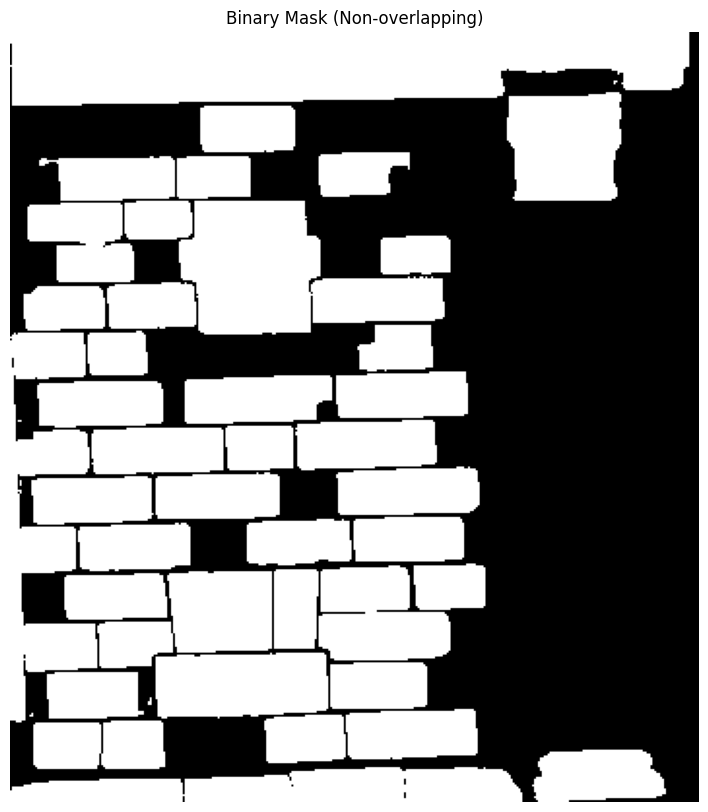

True

In [34]:
# Use the SAM masks to build the final binary mask.
# You can choose to use either `masks` or `masks2` depending on your needs.
total_mask = build_totalmask(masks)

# Save the binary mask to a file
cv2.imwrite('binary_mask.png', total_mask)

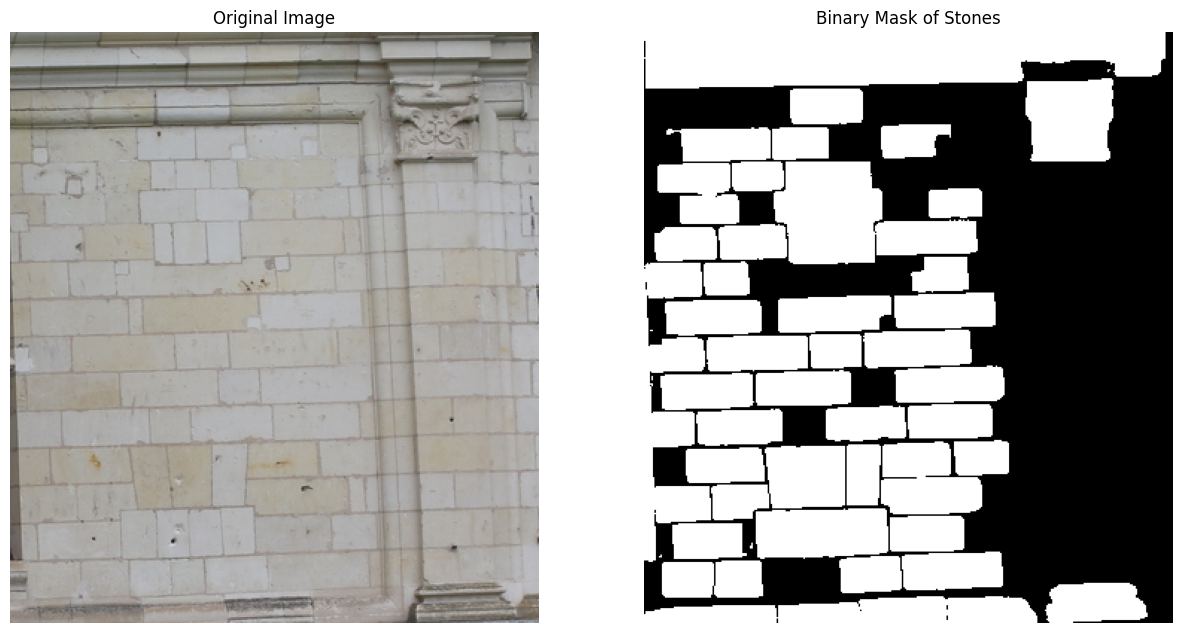

In [35]:
# Optional: Display the original image alongside the binary mask
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(total_mask, cmap='gray')
plt.title("Binary Mask of Stones")
plt.axis('off')
plt.show()

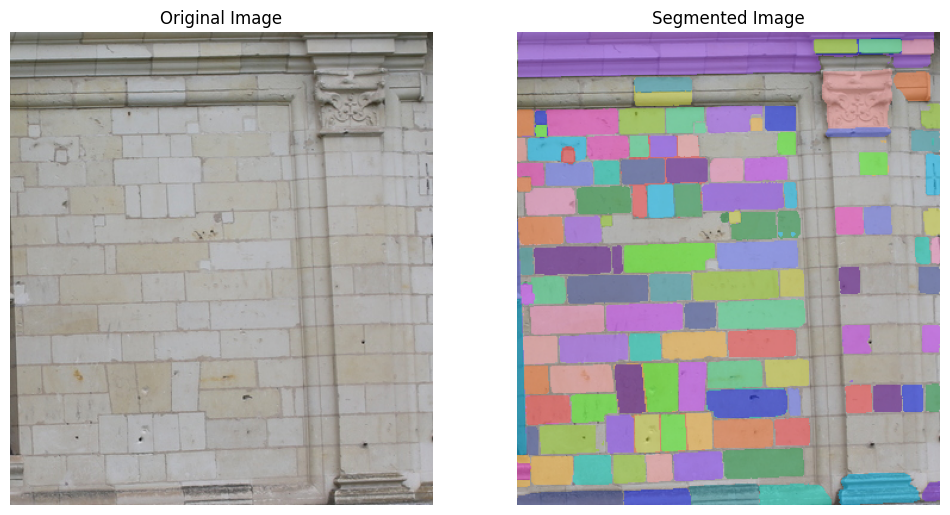

In [36]:
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['Original Image', 'Segmented Image']
)